# Preamble

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.array
import cartopy.crs as ccrs
import pickle
import matplotlib.colors as colors
import datetime as dt
import pickle
from matplotlib.colors import BoundaryNorm
import glob
import pdb
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings('ignore')

import calendar
import sys
sys.path.append('/home/563/ab2313/MJO/functions')
import access_functions as af
import subphase_calc_functions as subphase_calc
import access_plot_functions as apf
import load_dataset as load
import phase_calc_functions as phase_calc
from importlib import reload

import subphase_calc_2 as sub2

In [2]:
from importlib import reload

In [3]:
load = reload(load)
awap, access, rmm_obs, rmm_access = load.load_accessifies_variables()

4159 4159
4159 4159


In [4]:
# This way you don't have to reload all of the datasets if you want to reset them
awap_init = awap.copy(deep = True)
access_init = access.copy(deep = True)

# Raintype

In [5]:
awap = awap_init
access = access_init

In [6]:
access

<xarray.Dataset>
Dimensions:   (ensemble: 11, lat: 49, lon: 149, time: 4159)
Coordinates:
  * lat       (lat) float32 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * lon       (lon) float32 113.75 114.0 114.25 114.5 ... 150.25 150.5 150.75
  * time      (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2012-12-31
  * ensemble  (ensemble) int64 1 2 3 4 5 6 7 8 9 10 11
Data variables:
    precip    (ensemble, time, lat, lon) float32 nan nan nan nan ... nan nan nan
Attributes:
    Information:  Only contains the wet season [10,11,12,1,2,3],rainfall >= 1...
    Time:         Only for the wet-season

In [28]:
q = 90

# If q > 0, then awap will be the events above a certian percentile
if q:
    awap = scf.unsplit_find_events_above_q(awap, q)
    
    # Looping through ensemble
    ex_stor = []
    for ensemble in access.ensemble.values:  
        # Selecting a single ensemble
        access_single = access.sel(ensemble = ensemble)
        # Getting extrreme events
        access_90_single = scf.unsplit_find_events_above_q(access_single, q)
        
        ex_stor.append(access_90_single)
    access = xr.concat(ex_stor, pd.Index(access.ensemble.values, name = 'ensemble'))
    
else:
    q = 'all'

# Calculations

Splitting the normal events

In [29]:
subphase_calc = reload(subphase_calc)
# Split AWAP into the subphases: enhanced, suppressed, transition and inactive.
awap_split = subphase_calc.split_into_subphase(awap, rmm_obs)

In [30]:
import subphase_calc_functions as scf
import access_anomalies

In [31]:
access_anomalies = reload(access_anomalies)
import access_anomalies
awap_mean, awap_anomaly = access_anomalies.mean_and_anomly_month_subphase(awap_split, awap)

In [32]:
sub2 = reload(sub2)
af = reload(af)

mean_stor = []
anom_stor = []
    
# Looping through ensemble
for ensemble in access.ensemble.values:
    
    # Selecting a single ensemble
    access_single = access.sel(ensemble = ensemble)
    rmm_single = rmm_access.sel(ensemble = ensemble)
    
    # Splitting the rainfall in to the 9 mjo phases
    access_split = subphase_calc.split_into_subphase(access_single, rmm_single)
    
    # Calculating the index for a single ensemble
    access_mean_norm_single, access_anomaly_norm_single = \
                access_anomalies.mean_and_anomly_month_subphase(access_split, access_single)
    
    
    mean_stor.append(access_mean_norm_single)
    
    # For some reason the 11th ensebmle maintain the ensemble dimensin (???)
#     if ensemble == 11:
#         access_anomaly_norm_single = access_anomaly_norm_single.drop('ensemble')
    
    anom_stor.append(access_anomaly_norm_single)

    
    
# Storing all the results in a xarray files.
access_mean_total = xr.concat(mean_stor, dim = 'ensemble')
access_anom_total = xr.concat(anom_stor, dim = 'ensemble')

# Taking the mean across all ensembles

access_mean_mean = access_mean_total.mean(dim = 'ensemble').compute()

access_anom_mean = access_anom_total.mean(dim = 'ensemble').compute()

# Plots

In [33]:
savedir = '../images/access/pattern_correlation/'

## Map Plots

### Climatology

In [34]:
apf = reload(apf) 
apf.comparison_plot(awap_count, access_count_mean, month = 1,
                    plot_max = 90,  vmax = 2, add_white = 0,
                    rain_type = 'Percent of Days as Rainday',
                   cbar1_title = 'Percent of Days as Raindays', cbar2_title = 'ACCESS/AWAP Ratio',
                    savedir = savedir, savefig = 0
                  )

NameError: name 'awap_count' is not defined

In [ ]:
apf = reload(apf) 

for month in [10,11,12,1,2,3]:
    apf.comparison_plot(awap_count, access_count_mean, month = month,
                        plot_max = 90,  vmax = 2, add_white = 0,
                        rain_type = 'Percent of Days as Rainday',
                       cbar1_title = 'Percent of Days as Raindays', cbar2_title = 'ACCESS/AWAP Ratio',
                        savedir = savedir, savefig = 1
                      )

### Anomaly

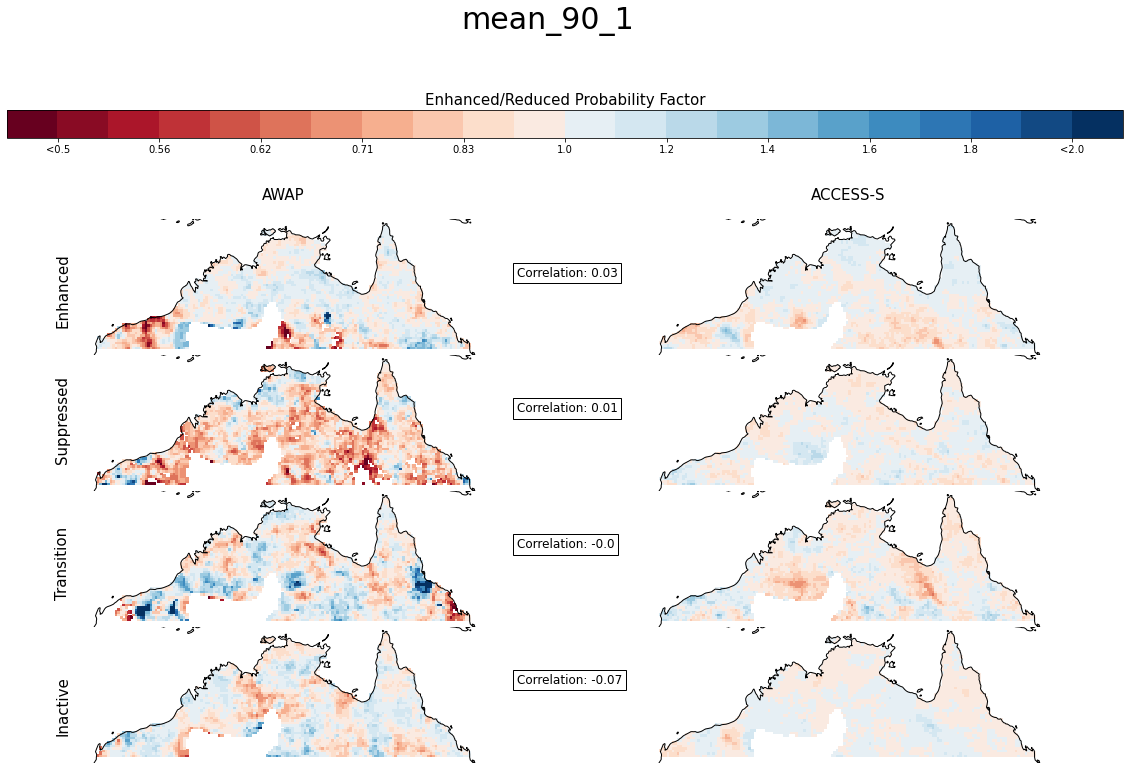

In [35]:
apf = reload(apf)
month = 1
apf.anomaly_plot_subphases(awap_anomaly,access_anom_mean , month = month
                          ,vmax = 2.1, cbar_title = 'Enhanced/Reduced Probability Factor',
                          savename = f'mean_{q}_{month}')

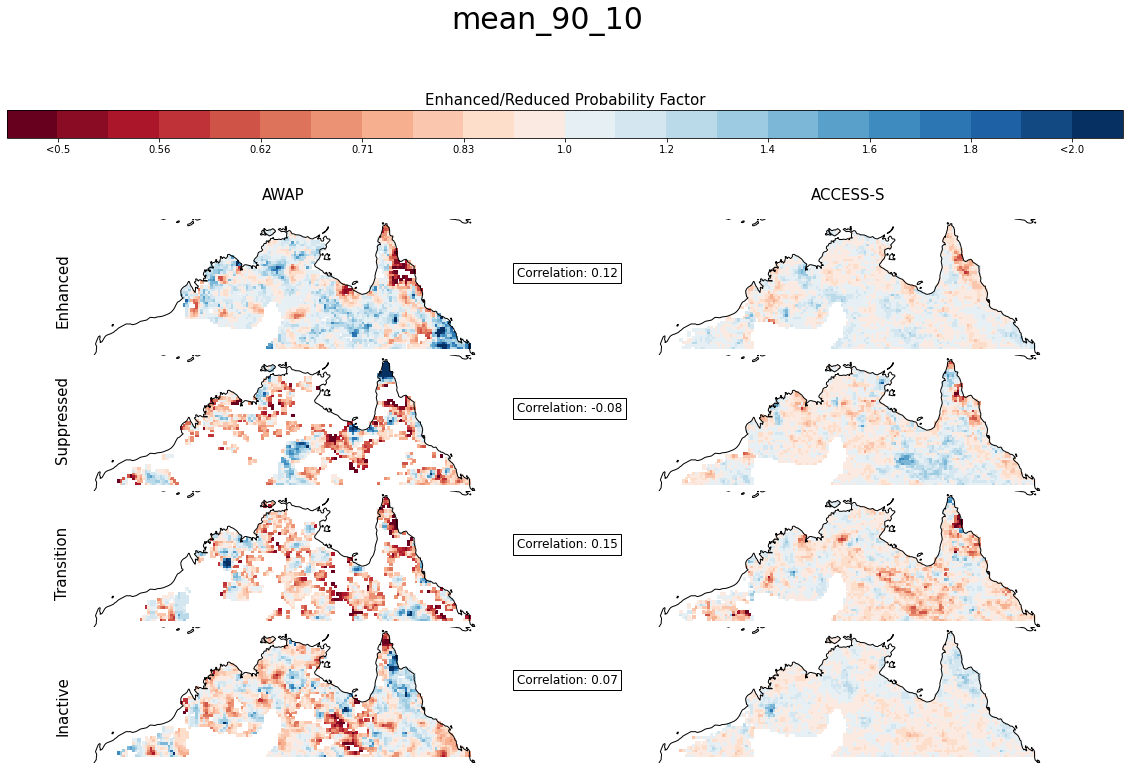

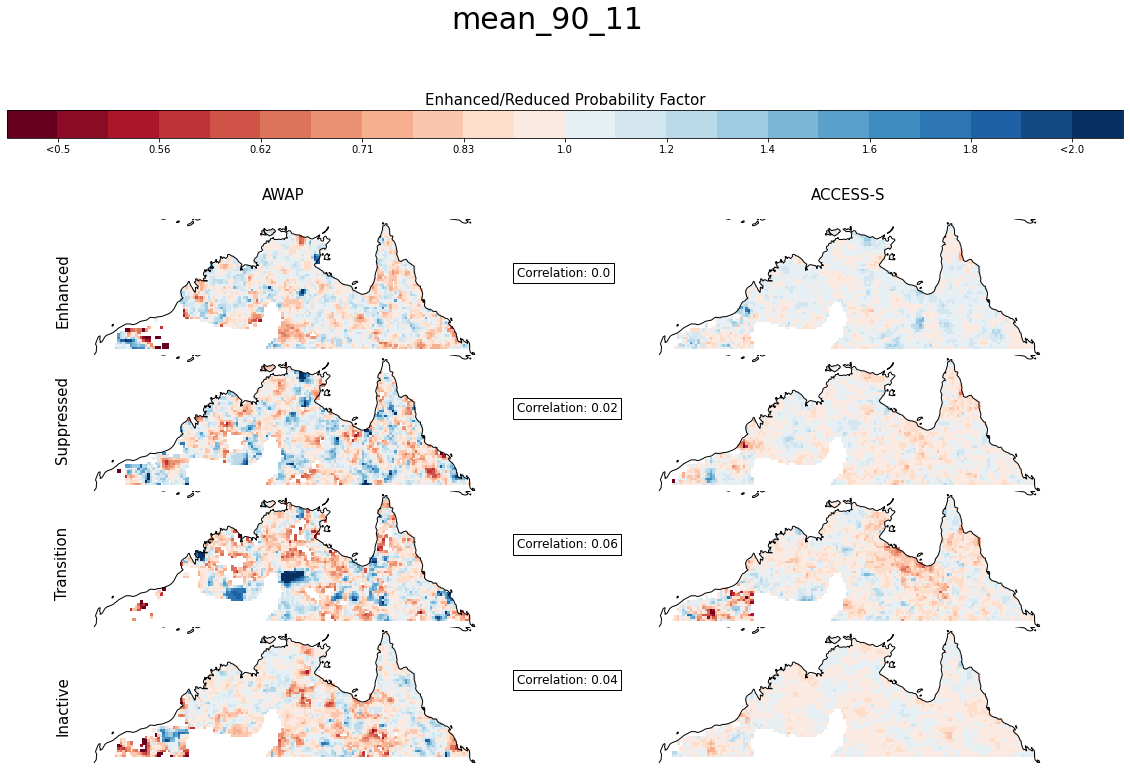

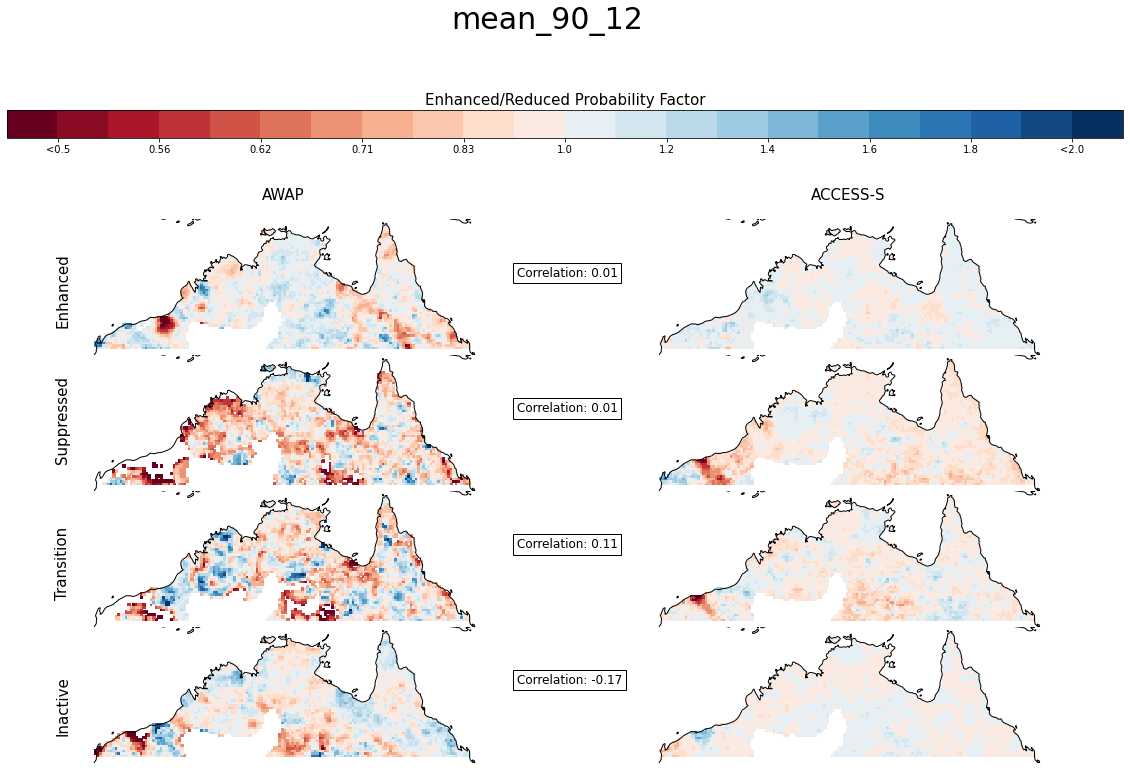

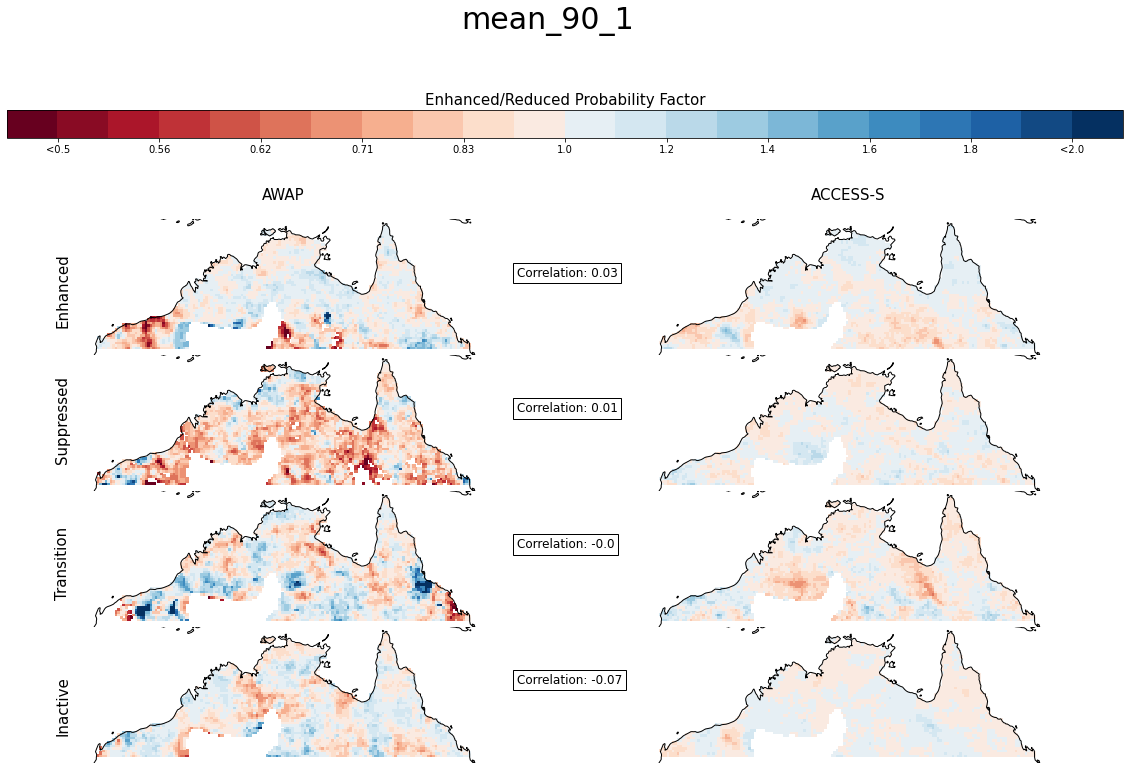

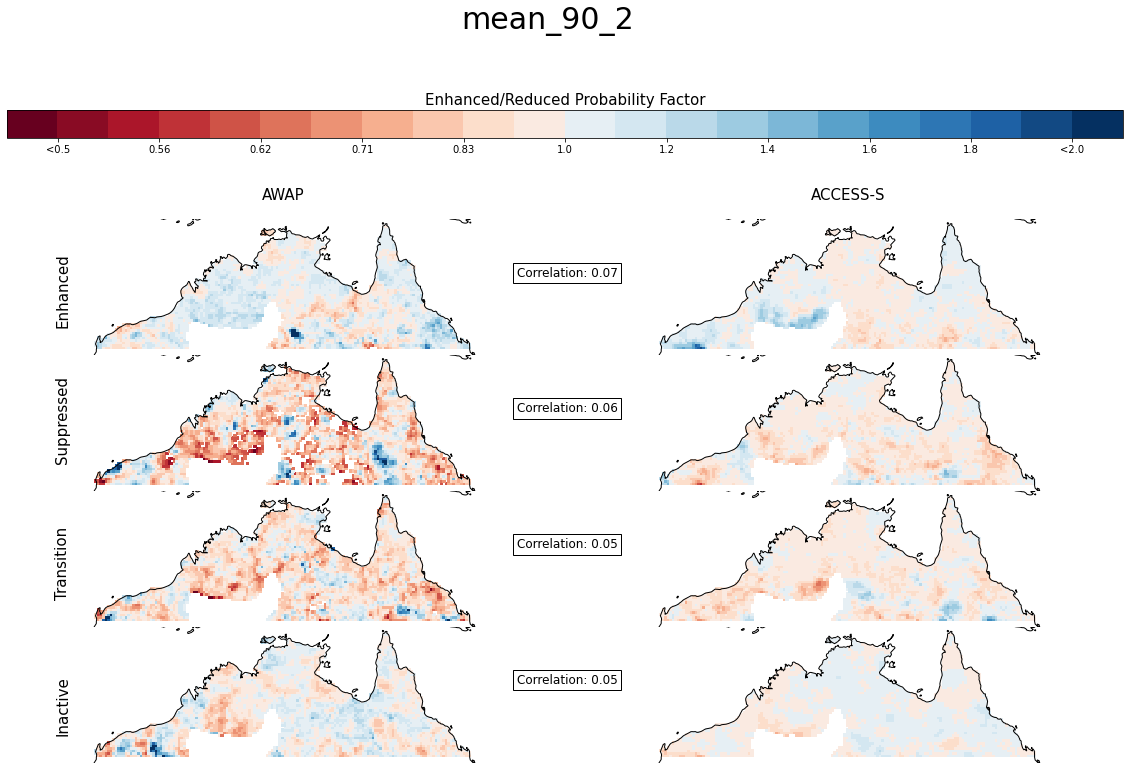

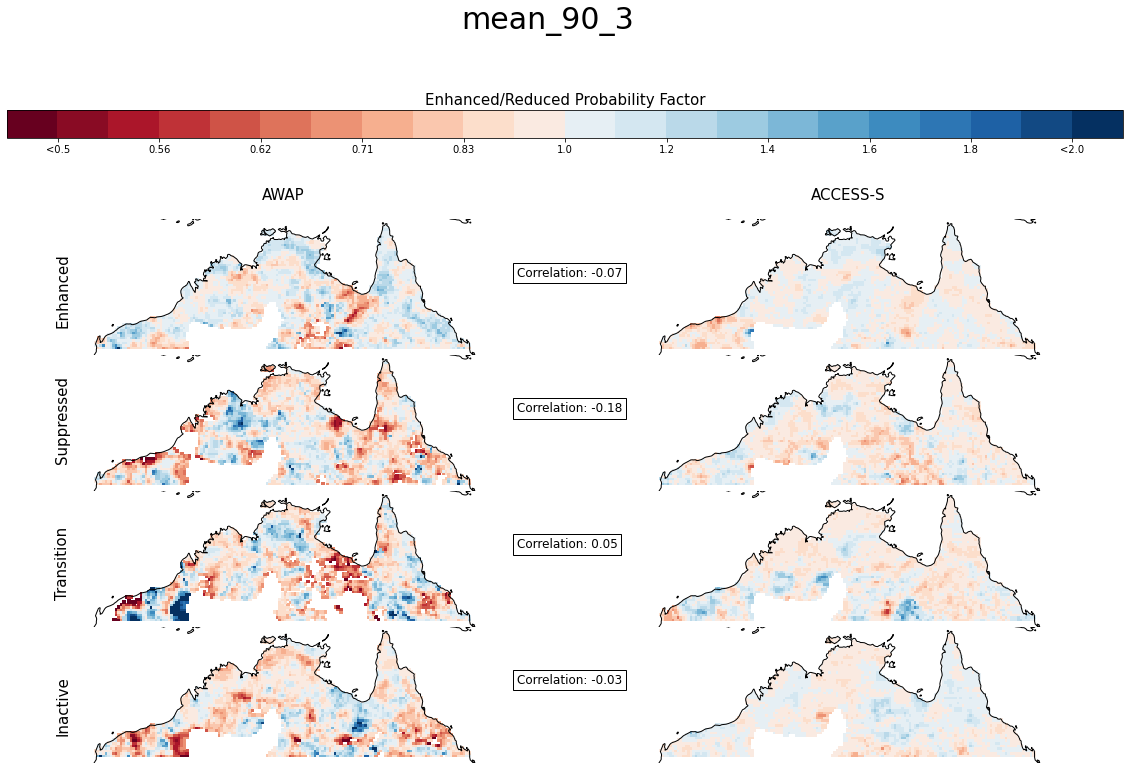

In [36]:
apf = reload(apf)

for month in [10,11,12,1,2,3]:

    apf.anomaly_plot_subphases(awap_anomaly,access_anom_mean , month = month
                              ,vmax = 2.1, cbar_title = 'Enhanced/Reduced Probability Factor',
                              savename = f'mean_{q}_{month}', savedir =  savedir)


## Timeseries Correlations

### Climatology

In [ ]:
af = reload(af)
pattern_correlation = af.month_pattern_correlations(awap_count, access_count_mean)

In [ ]:
apf = reload(apf)

title = 'Monthly Pattern Colleration\nfor Percent of Days as Raindays'

apf.timeseries_pattern_correlation_plot(pattern_correlation,title = title, custom = 0, savefig = 1, savedir = savedir)

In [ ]:
af = reload(af)
ensemble_raw_correlation = af. list_pattern_correlation(awap_count, count_stor)

In [ ]:
afp2 = reload(afp2)


title = 'All Ensmeble Monthly Pattern Colleration\nfor Percent of Days as Raindays'
afp2.stacked_patter_correlation_timeseries(ensemble_raw_correlation, title = title, savefig = 1, savedir = savedir)

### Anomalies

In [37]:
af = reload(af)
anomaly_patterns = af.month_pattern_correlations(awap_anomaly,access_anom_mean)

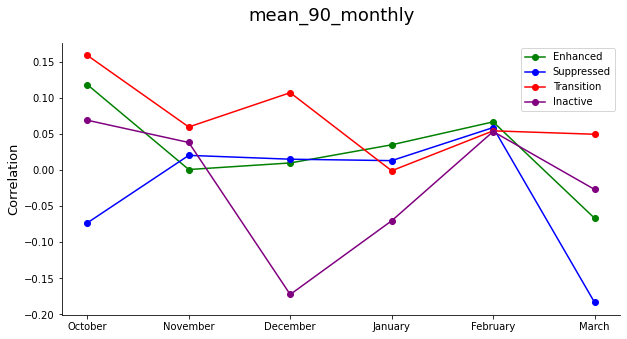

In [38]:
apf = reload(apf)

savename = f'mean_{q}_monthly'

apf.timeseries_pattern_correlation_plot(anomaly_patterns,
                                        custom  = 0, 
                                        savename = savename, savedir = savedir)

<br>
Correlation of the raw count index with awap
<br> <br>
<br>


In [39]:
af = reload(af)
ensemble_anom_correlation = af. list_pattern_correlation(awap_anomaly, anom_stor)

In [40]:
import access_plot_functions_2 as afp2

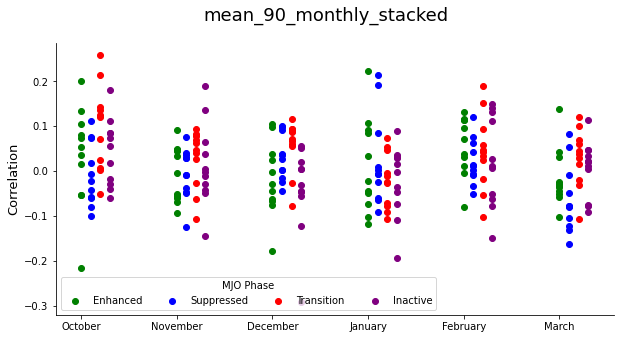

In [41]:
afp2 = reload(afp2)
savename = f'mean_{q}_monthly_stacked'

afp2.stacked_patter_correlation_timeseries(ensemble_anom_correlation, savename = savename,
                                        savedir = savedir)

### Heatmaps

In [42]:
import access_heatmaps_corr as heat_corr

In [43]:
heat_corr = reload(heat_corr)

count_pcorr_all_state = heat_corr.pattern_corr_state(awap_anomaly,access_anom_mean)

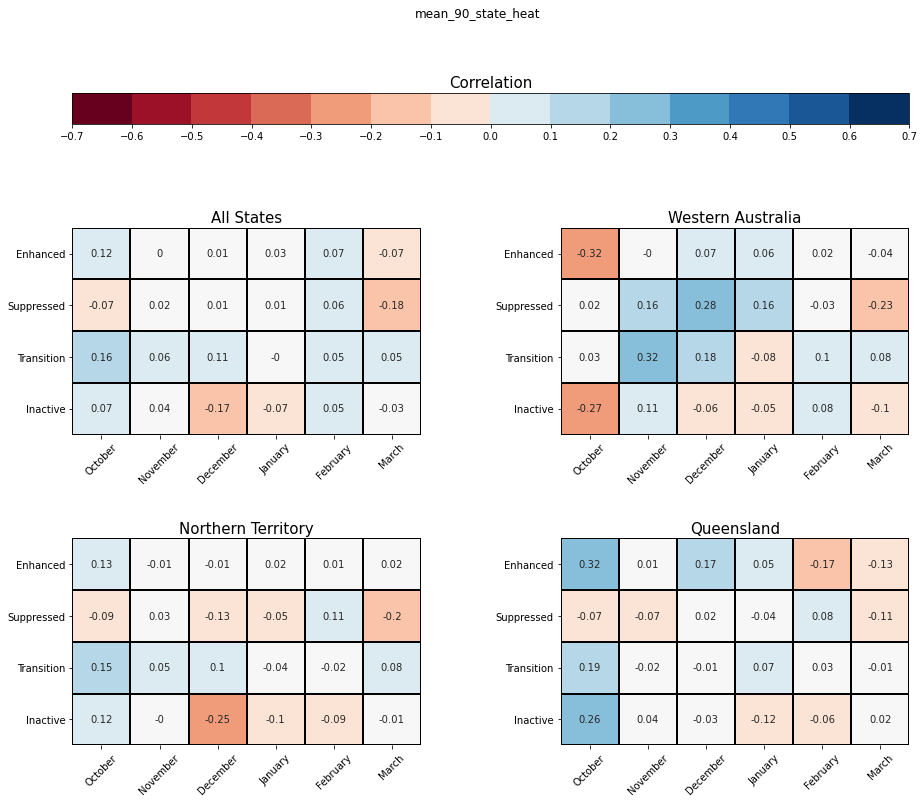

In [44]:
heat_corr = reload(heat_corr)
heat_corr.corr_heatmap_state_group(count_pcorr_all_state.correlation.transpose(), month_reverse = 0
                 , vmax = 0.7,step = 0.1, add_white = 1,
                 savename = f'mean_{q}_state_heat'
                                   , savedir = savedir)

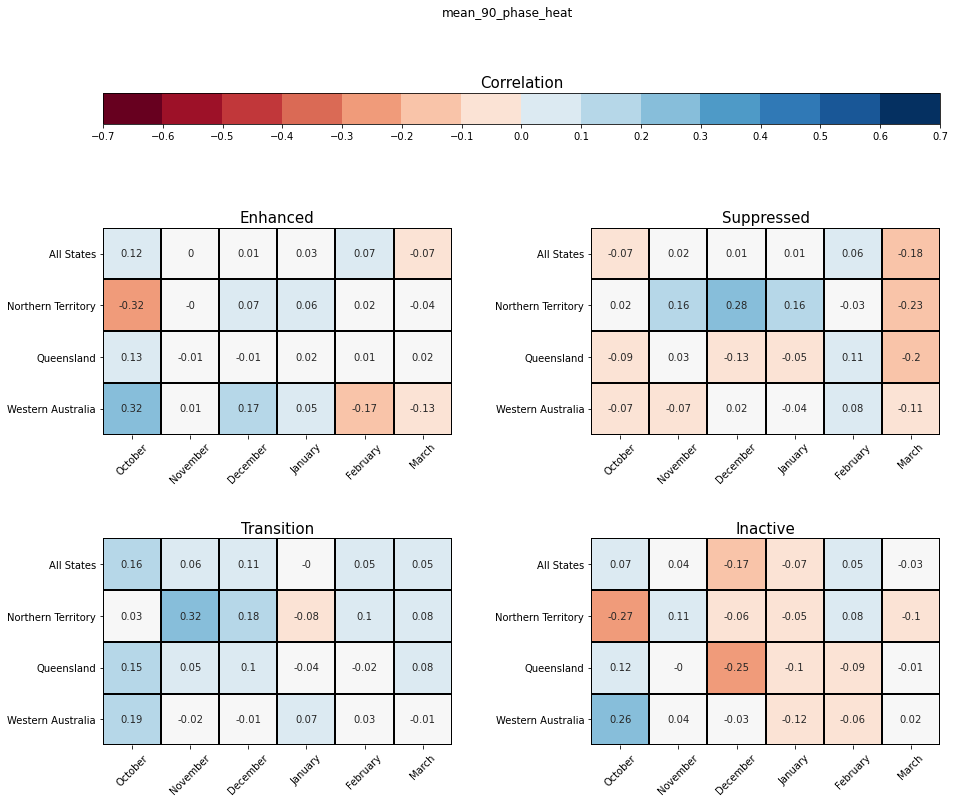

In [45]:
heat_corr = reload(heat_corr)
heat_corr.corr_heatmap_phase_group(count_pcorr_all_state.correlation.transpose(), month_reverse = 0
                 , vmax = 0.7,step = 0.1, add_white = 1,
                 savename = f'mean_{q}_phase_heat'
                                   , savedir = savedir)